<a href="https://colab.research.google.com/github/KaizenGirl1111/hahah/blob/master/guess%20whose%20painting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import time, os, copy, argparse
import multiprocessing

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"


In [3]:
!pip install kaggle


In [4]:
!kaggle datasets download -d delayedkarma/impressionist-classifier-data


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /content. Or use the environment method.


In [5]:
!unzip impressionist-classifier-data.zip -d impressionist_dataset

unzip:  cannot find or open impressionist-classifier-data.zip, impressionist-classifier-data.zip.zip or impressionist-classifier-data.zip.ZIP.


In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd

Number of painters: 10
Painter names: ['Cezanne', 'Sargent', 'Matisse', 'Pissarro', 'Degas', 'VanGogh', 'Gauguin', 'Renoir', 'Monet', 'Hassam']


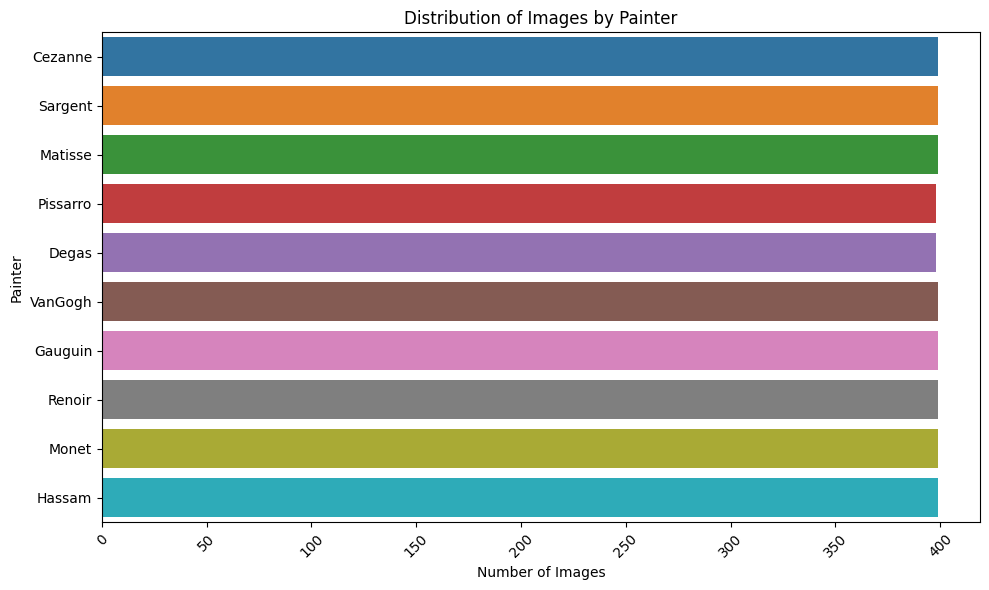

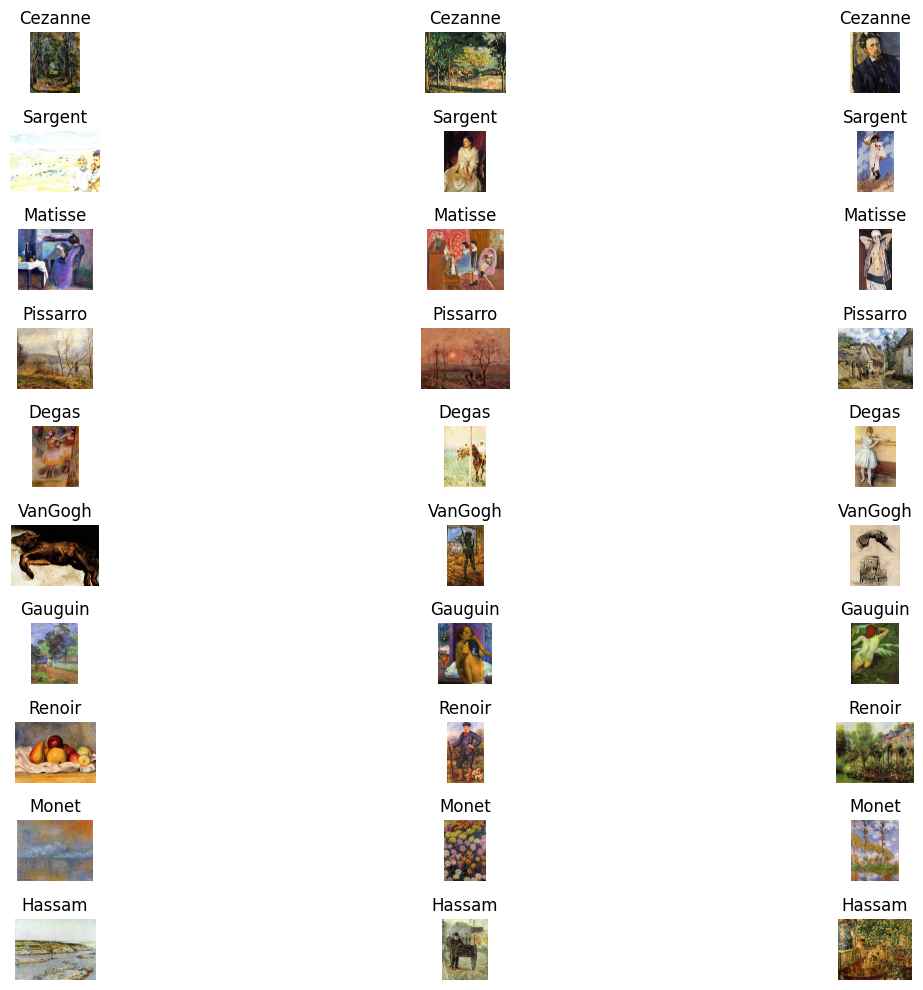

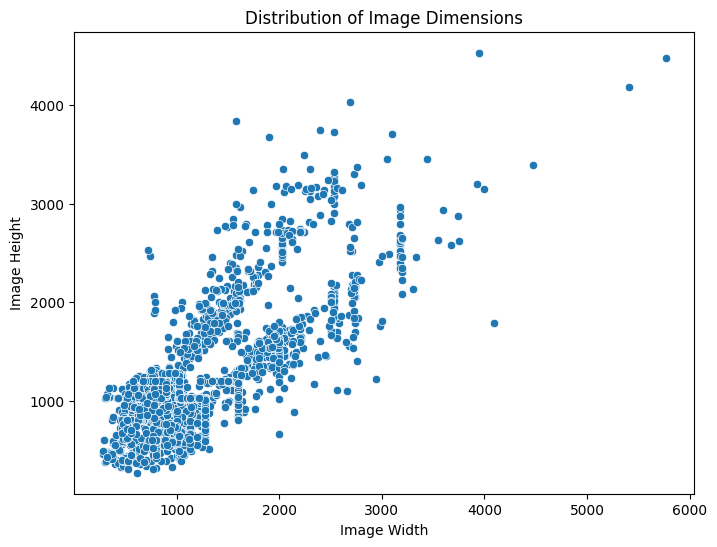

In [12]:
  # Directory where the dataset is extracted

# Path to the dataset directory
# Path to the dataset directory
dataset_dir = 'impressionist_dataset'
training_dir = os.path.join(dataset_dir, 'training', 'training')  # Corrected path

# List of painters (class names)
painters = os.listdir(training_dir)
num_painters = len(painters)

print(f"Number of painters: {num_painters}")
print("Painter names:", painters)

# Distribution of images by painter
painter_counts = [len(os.listdir(os.path.join(training_dir, painter))) for painter in painters]

plt.figure(figsize=(10, 6))
sns.barplot(x=painter_counts, y=painters)
plt.xlabel("Number of Images")
plt.ylabel("Painter")
plt.title("Distribution of Images by Painter")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sample images from each painter
num_samples = 3

plt.figure(figsize=(15, 10))

for painter in painters:
    painter_dir = os.path.join(training_dir, painter)
    sample_images = os.listdir(painter_dir)[:num_samples]

    for idx, image_name in enumerate(sample_images):
        image_path = os.path.join(painter_dir, image_name)
        if os.path.isfile(image_path):  # Check if the path is a file
            image = Image.open(image_path)
            plt.subplot(num_painters, num_samples, idx + 1 + painters.index(painter) * num_samples)
            plt.imshow(image)
            plt.title(painter)
            plt.axis('off')

plt.tight_layout()
plt.show()

# Image dimensions
image_dimensions = []

for painter in painters:
    painter_dir = os.path.join(training_dir, painter)
    image_names = os.listdir(painter_dir)
    for image_name in image_names:
        image_path = os.path.join(painter_dir, image_name)
        if os.path.isfile(image_path):  # Check if the path is a file
            image = Image.open(image_path)
            width, height = image.size
            image_dimensions.append((width, height))

df_dimensions = pd.DataFrame(image_dimensions, columns=['Width', 'Height'])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_dimensions, x='Width', y='Height')
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Distribution of Image Dimensions")
plt.show()

In [14]:
def vgg_block_single(in_ch,out_ch,kernel_size=3,padding=1):
    return nn.Sequential(
    nn.Conv2d(in_ch,out_ch,kernel_size=kernel_size,padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
def vgg_block_double(in_ch, out_ch, kernel_size=3, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding),
        nn.ReLU(),
        nn.Conv2d(out_ch, out_ch, kernel_size=kernel_size, padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
        )

#we define 2 blocks as the single layer block helps to extract simple features and the double layer block helps in extracting more sublte features due to more max_pooling
class MyVGG11(nn.Module):
    def __init__(self, in_ch, num_classes):
        super().__init__()

        self.conv_block1 =vgg_block_single(in_ch,64)
        self.conv_block2 =vgg_block_single(64,128)

        self.conv_block3 =vgg_block_double(128,256)
        self.conv_block4 =vgg_block_double(256,512)
        self.conv_block5 =vgg_block_double(512,512)

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), nn.ReLU(inplace=True), nn.Dropout(),
            nn.Linear(4096, 4096), nn.ReLU(inplace=True), nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):

        x=self.conv_block1(x)
        x=self.conv_block2(x)

        x=self.conv_block3(x)
        x=self.conv_block4(x)
        x=self.conv_block5(x)

        x=x.view(x.size(0), -1)

        x=self.fc_layers(x)

        return x

In [15]:
train_directory = '/content/impressionist_dataset/training/training'
valid_directory = '/content/impressionist_dataset/validation/validation'

In [16]:
bs = 64
# Number of epochs
num_epochs = 10
# Number of classes
num_classes = 10

In [17]:
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256,scale=[0.8,1.0]),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [18]:
dataset = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Size of train and validation data
dataset_sizes = {
    'train':len(dataset['train']),
    'valid':len(dataset['valid'])
}

In [19]:
dataloaders = {
    'train':data.DataLoader(dataset['train'], batch_size=bs, shuffle=True, pin_memory=True, drop_last=True),
    'valid':data.DataLoader(dataset['valid'], batch_size=bs, shuffle=True, pin_memory=True, drop_last=True)
}

# Class names or target labels
class_names = dataset['train'].classes
print("Classes:", class_names)

# Print the train and validation data sizes
print("Training-set size:",dataset_sizes['train'],
      "\nValidation-set size:", dataset_sizes['valid'])

# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Classes: ['Cezanne', 'Degas', 'Gauguin', 'Hassam', 'Matisse', 'Monet', 'Pissarro', 'Renoir', 'Sargent', 'VanGogh']
Training-set size: 3988 
Validation-set size: 990


In [20]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features #update the fc layer to correctly fit into the output classes neurons
model_ft.fc = nn.Linear(num_ftrs,num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


In [21]:
model_ft = model_ft.to(device)

In [22]:
pip install torchsummary

In [23]:
from torchsummary import summary
print('Model Summary:-\n')
for num, (name, param) in enumerate(model_ft.named_parameters()):
    print(num, name, param.requires_grad )
summary(model_ft, input_size=(3, 224, 224))
print(model_ft)

Model Summary:-

0 conv1.weight True
1 bn1.weight True
2 bn1.bias True
3 layer1.0.conv1.weight True
4 layer1.0.bn1.weight True
5 layer1.0.bn1.bias True
6 layer1.0.conv2.weight True
7 layer1.0.bn2.weight True
8 layer1.0.bn2.bias True
9 layer1.1.conv1.weight True
10 layer1.1.bn1.weight True
11 layer1.1.bn1.bias True
12 layer1.1.conv2.weight True
13 layer1.1.bn2.weight True
14 layer1.1.bn2.bias True
15 layer2.0.conv1.weight True
16 layer2.0.bn1.weight True
17 layer2.0.bn1.bias True
18 layer2.0.conv2.weight True
19 layer2.0.bn2.weight True
20 layer2.0.bn2.bias True
21 layer2.0.downsample.0.weight True
22 layer2.0.downsample.1.weight True
23 layer2.0.downsample.1.bias True
24 layer2.1.conv1.weight True
25 layer2.1.bn1.weight True
26 layer2.1.bn1.bias True
27 layer2.1.conv2.weight True
28 layer2.1.bn2.weight True
29 layer2.1.bn2.bias True
30 layer3.0.conv1.weight True
31 layer3.0.bn1.weight True
32 layer3.0.bn1.bias True
33 layer3.0.conv2.weight True
34 layer3.0.bn2.weight True
35 layer3.0.b

In [24]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Learning rate decay
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Model training routine
print("\nTraining:-\n")
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Tensorboard summary
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Record training loss and accuracy for each phase
            if phase == 'train':
                writer.add_scalar('Train/Loss', epoch_loss, epoch)
                writer.add_scalar('Train/Accuracy', epoch_acc, epoch)
                writer.flush()
            else:
                writer.add_scalar('Valid/Loss', epoch_loss, epoch)
                writer.add_scalar('Valid/Accuracy', epoch_acc, epoch)
                writer.flush()

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


Training:-



In [25]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 1.8970 Acc: 0.3581
valid Loss: 1.3734 Acc: 0.5394

Epoch 1/9
----------
train Loss: 1.1695 Acc: 0.6404
valid Loss: 1.0255 Acc: 0.6414

Epoch 2/9
----------
train Loss: 0.8864 Acc: 0.7192
valid Loss: 0.8619 Acc: 0.6747

Epoch 3/9
----------
train Loss: 0.7280 Acc: 0.7686
valid Loss: 0.7762 Acc: 0.7111

Epoch 4/9
----------
train Loss: 0.6243 Acc: 0.8022
valid Loss: 0.7298 Acc: 0.7222

Epoch 5/9
----------
train Loss: 0.5438 Acc: 0.8275
valid Loss: 0.7083 Acc: 0.7364

Epoch 6/9
----------
train Loss: 0.4933 Acc: 0.8440
valid Loss: 0.6722 Acc: 0.7434

Epoch 7/9
----------
train Loss: 0.4333 Acc: 0.8588
valid Loss: 0.6540 Acc: 0.7434

Epoch 8/9
----------
train Loss: 0.4290 Acc: 0.8666
valid Loss: 0.6497 Acc: 0.7505

Epoch 9/9
----------
train Loss: 0.4153 Acc: 0.8706
valid Loss: 0.6495 Acc: 0.7465

Training complete in 213m 1s
Best val Acc: 0.750505


In [26]:
PATH="model_1.pth"
print("\nSaving the model...")
torch.save(model_ft, PATH)


Saving the model...


In [27]:
EVAL_MODEL='/content/model_1.pth'
model = torch.load(EVAL_MODEL)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
from IPython.display import FileLink
FileLink(r'./model_1.pth')

/content/model_1.pth

In [42]:
import os
import torch
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix

# Set batch size and paths
bs = 8
EVAL_DIR = '/content/impressionist_dataset/testing/testing/'  # Update this path to match the location of your test images

# Load the model
MODEL_PATH = '/content/model_1.pth'  # Update this path to match the location of your model checkpoint
model = torch.load(MODEL_PATH)
model.eval()
def is_valid_file(filename):
    return filename.lower().endswith(('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp'))

# Prepare the eval data loader
eval_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

eval_dataset = datasets.ImageFolder(root=EVAL_DIR, transform=eval_transform)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=bs, shuffle=True, pin_memory=True)

# Enable GPU mode if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Number of classes and dataset-size
num_classes = len(eval_dataset.classes)
dsize = len(eval_dataset)

# Class label names
class_names = eval_dataset.classes

# Initialize the prediction and label lists
predlist = torch.zeros(0, dtype=torch.long, device=device)
lbllist = torch.zeros(0, dtype=torch.long, device=device)

# Evaluate the model accuracy on the dataset
correct = 0
total = 0
with torch.no_grad():
    for subdir, _, files in os.walk(EVAL_DIR):
        for image_name in files:
            image_path = os.path.join(subdir, image_name)
            image = Image.open(image_path).convert("RGB")
            image = eval_transform(image).unsqueeze(0).to(device)
            labels = class_names.index(os.path.basename(subdir))

            outputs = model(image)
            _, predicted = torch.max(outputs.data, 1)

            total += 1
            correct += (predicted == labels).sum().item()

            predlist = torch.cat([predlist, predicted.view(-1)])
            lbllist = torch.cat([lbllist, labels])

# Overall accuracy
overall_accuracy = 100 * correct / total
print('Accuracy of the network on the {:d} test images: {:.2f}%'.format(dsize, overall_accuracy))

# Confusion matrix
conf_mat = confusion_matrix(lbllist.cpu().numpy(), predlist.cpu().numpy())
print('Confusion Matrix')
print('-' * 16)
print(conf_mat, '\n')



FileNotFoundError: ignored